### Packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order_combined as data
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

importing Jupyter notebook from data_clean_order_combined.ipynb
Length of original data set 209527
Number of examples with no short description:  19712
Number of examples with no headline:  6


c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anacond

Stored 'test_df' (DataFrame)
Size of training data for combined:  167616
Size of testing data for combined:  41905
Stored 'rand_shuffled_text' (DataFrame)
Stored 'ordered_super_alpha_text' (DataFrame)
Stored 'ordered_class_alpha_text' (DataFrame)
Stored 'ordered_sem_clusters_desc_text' (DataFrame)
Stored 'ordered_sem_clusters_asc_text' (DataFrame)
Stored 'ordered_sem_clusters_shuffled_per_superclass_text' (DataFrame)


### Loading ordered data from data_clean_order_text.ipynb

In [2]:
%store -r rand_shuffled_text
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [3]:
# Experimental data orderings on headlines TRAIN EXAMPLES
XB_train = rand_shuffled_text['combined']
X1_train = ordered_super_alpha_text['combined']
X2_train = ordered_class_alpha_text['combined']
X3_train = ordered_sem_clusters_desc_text['combined']
X4_train = ordered_sem_clusters_asc_text['combined']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['combined']

# Experimental data orderings on short_description #TODO

# TRAIN LABELS
YB_train = rand_shuffled_text['superclass']
Y1_train = ordered_super_alpha_text['superclass']
Y2_train = ordered_class_alpha_text['superclass']
Y3_train = ordered_sem_clusters_desc_text['superclass']
Y4_train = ordered_sem_clusters_asc_text['superclass']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['superclass']

# TEST EXAMPLES
X_test = test_df['combined']
Y_test = test_df['superclass']

In [5]:
YB_train[:100]

8452        COMMUNITIES
42174          POLITICS
90062            HEALTH
119426           SOCIAL
127707     SCIENCE_TECH
              ...      
50933     ENTERTAINMENT
16344          POLITICS
188010           HEALTH
51872          POLITICS
164258           FAMILY
Name: superclass, Length: 100, dtype: object

In [6]:
Y1_train[:100]

0     COMMUNITIES
1     COMMUNITIES
2     COMMUNITIES
3     COMMUNITIES
4     COMMUNITIES
         ...     
95    COMMUNITIES
96    COMMUNITIES
97    COMMUNITIES
98    COMMUNITIES
99    COMMUNITIES
Name: superclass, Length: 100, dtype: object

In [7]:
Y2_train[:100]

0     CULTURE
1     CULTURE
2     CULTURE
3     CULTURE
4     CULTURE
       ...   
95    CULTURE
96    CULTURE
97    CULTURE
98    CULTURE
99    CULTURE
Name: superclass, Length: 100, dtype: object

In [8]:
Y3_train[:100]

124413    POLITICS
30957     POLITICS
24312     POLITICS
7288      POLITICS
27077     POLITICS
            ...   
19524     POLITICS
36084     POLITICS
122753    POLITICS
69285     POLITICS
25933     POLITICS
Name: superclass, Length: 100, dtype: object

In [9]:
Y4_train[:100]

172426    CULTURE
176361    CULTURE
151252    CULTURE
141925    CULTURE
198486    CULTURE
           ...   
143854    CULTURE
648       CULTURE
167684    CULTURE
169692    CULTURE
164990    CULTURE
Name: superclass, Length: 100, dtype: object

In [10]:
Y5_train[:100]

76371     POLITICS
57754     POLITICS
101093    POLITICS
43345     POLITICS
67186     POLITICS
            ...   
113389    POLITICS
68705     POLITICS
89854     POLITICS
129676    POLITICS
61466     POLITICS
Name: superclass, Length: 100, dtype: object

In [11]:
Y_test[:100]

54871        POLITICS
25625        POLITICS
48772     COMMUNITIES
114382      LIFESTYLE
75653        POLITICS
             ...     
6049         POLITICS
23369       LIFESTYLE
29132        POLITICS
137626         HEALTH
90732        POLITICS
Name: superclass, Length: 100, dtype: object

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [4]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


In [9]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

# BASELINE ORDER - RAND SHUFFLED

In [14]:
# BASELINE TRAIN DATA
X_train = XB_train
Y_train = YB_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model training using embedding layer and RNN 

In [15]:
# basline model using embedding layers and simpleRNN
modelB = Sequential()
modelB.add(Embedding(total_words, 70, input_length=maxlen))
modelB.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
modelB.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
modelB.add(SimpleRNN(32, activation='tanh'))
modelB.add(Dropout(0.2))
modelB.add(Dense(9, activation='softmax'))
modelB.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 70)            6238540   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          17280     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 9)                 2

In [16]:
modelB.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
historyB = modelB.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1048/1048 [==============================] - 122s 106ms/step - loss: 1.6799 - accuracy: 0.4203 - val_loss: 1.2955 - val_accuracy: 0.5727
Epoch 2/15
1048/1048 [==============================] - 107s 102ms/step - loss: 1.2495 - accuracy: 0.6021 - val_loss: 1.2010 - val_accuracy: 0.6231
Epoch 3/15
1048/1048 [==============================] - 109s 104ms/step - loss: 1.1442 - accuracy: 0.6382 - val_loss: 1.2353 - val_accuracy: 0.6128
Epoch 4/15
1048/1048 [==============================] - 101s 96ms/step - loss: 1.0586 - accuracy: 0.6707 - val_loss: 1.1311 - val_accuracy: 0.6498
Epoch 5/15
1048/1048 [==============================] - 106s 101ms/step - loss: 0.9878 - accuracy: 0.6984 - val_loss: 1.1283 - val_accuracy: 0.6500
Epoch 6/15
1048/1048 [==============================] - 107s 102ms/step - loss: 0.9415 - accuracy: 0.7145 - val_loss: 1.1574 - val_accuracy: 0.6447
Epoch 7/15
1048/1048 [==============================] - 99s 94ms/step - loss: 0.9055 - accuracy: 0.7260 - val_los

Test loss and accuracy: 3.229133129119873 0.17222288250923157


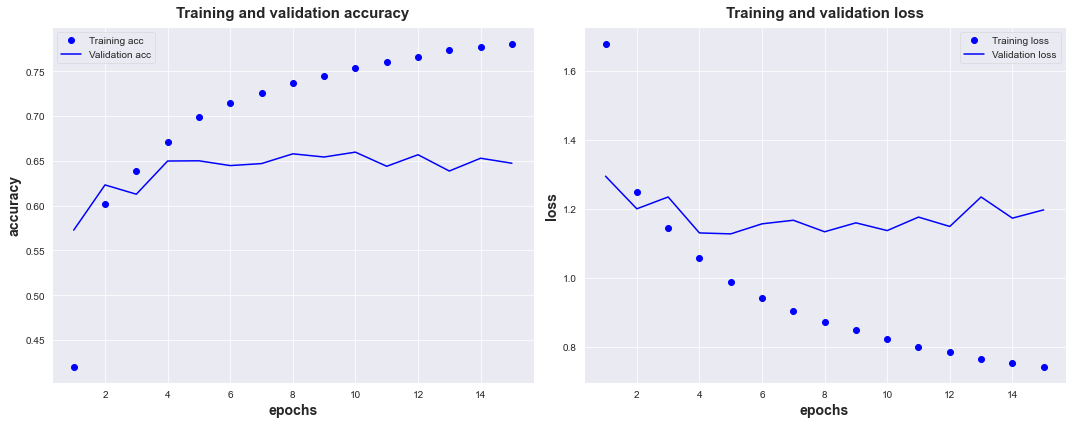

(41905,) (41905,)
[6 6 0 5 6] [4 6 3 6 6]
              precision    recall  f1-score   support

           0       0.07      0.07      0.07      3165
           1       0.03      0.03      0.03      1379
           2       0.20      0.23      0.21      8052
           3       0.12      0.07      0.08      4003
           4       0.15      0.09      0.11      5817
           5       0.16      0.14      0.15      4945
           6       0.26      0.33      0.29      9846
           7       0.06      0.08      0.07      2316
           8       0.08      0.06      0.07      2382

    accuracy                           0.17     41905
   macro avg       0.12      0.12      0.12     41905
weighted avg       0.16      0.17      0.17     41905



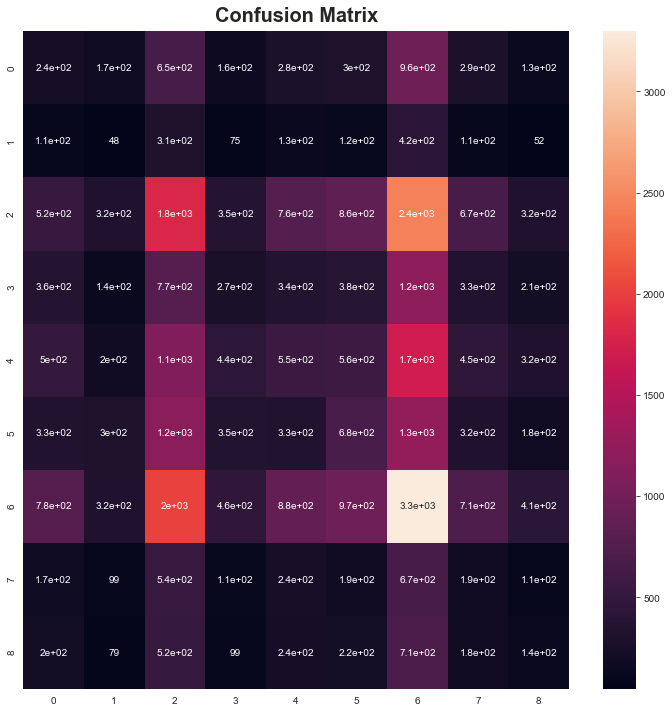

In [17]:
# evalute the model
test_loss, test_acc = modelB.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(historyB)

Y_pred = modelB.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 1

In [18]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model training using embedding layer and RNN 

In [19]:
# basline model using embedding layers and simpleRNN
model1 = Sequential()
model1.add(Embedding(total_words, 70, input_length=maxlen))
model1.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model1.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model1.add(SimpleRNN(32, activation='tanh'))
model1.add(Dropout(0.2))
model1.add(Dense(9, activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 70)            6238540   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                

In [20]:
model1.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history1 = model1.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 114s 99ms/step - loss: 0.2565 - accuracy: 0.9582 - val_loss: 6.5332 - val_accuracy: 0.4291
Epoch 2/15
1048/1048 [==============================] - 103s 98ms/step - loss: 0.1633 - accuracy: 0.9784 - val_loss: 8.3349 - val_accuracy: 0.4291
Epoch 3/15
1048/1048 [==============================] - 101s 96ms/step - loss: 0.1579 - accuracy: 0.9767 - val_loss: 8.8363 - val_accuracy: 0.4291
Epoch 4/15
1048/1048 [==============================] - 107s 102ms/step - loss: 0.1302 - accuracy: 0.9801 - val_loss: 9.6690 - val_accuracy: 0.4291
Epoch 5/15
1048/1048 [==============================] - 112s 107ms/step - loss: 0.1421 - accuracy: 0.9786 - val_loss: 9.8025 - val_accuracy: 0.4291
Epoch 6/15
1048/1048 [==============================] - 109s 104ms/step - loss: 0.1167 - accuracy: 0.9809 - val_loss: 10.5082 - val_accuracy: 0.4291
Epoch 7/15
1048/1048 [==============================] - 103s 99ms/step - loss: 0.1303 - accuracy: 0.9819 - val_los

Test loss and accuracy: 14.570313453674316 0.23496003448963165


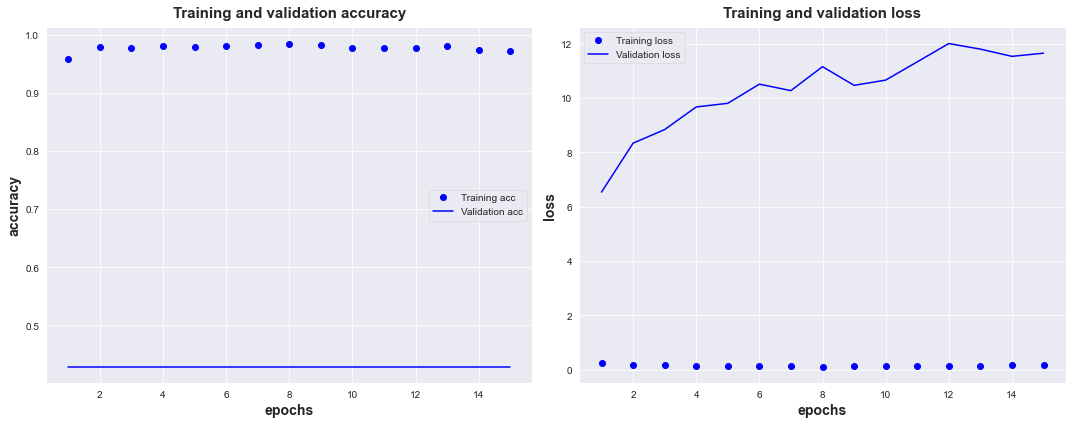

(41905,) (41905,)
[6 6 0 5 6] [6 6 6 6 6]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3165
           1       0.00      0.00      0.00      1379
           2       0.00      0.00      0.00      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.23      1.00      0.38      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.23     41905
   macro avg       0.03      0.11      0.04     41905
weighted avg       0.06      0.23      0.09     41905



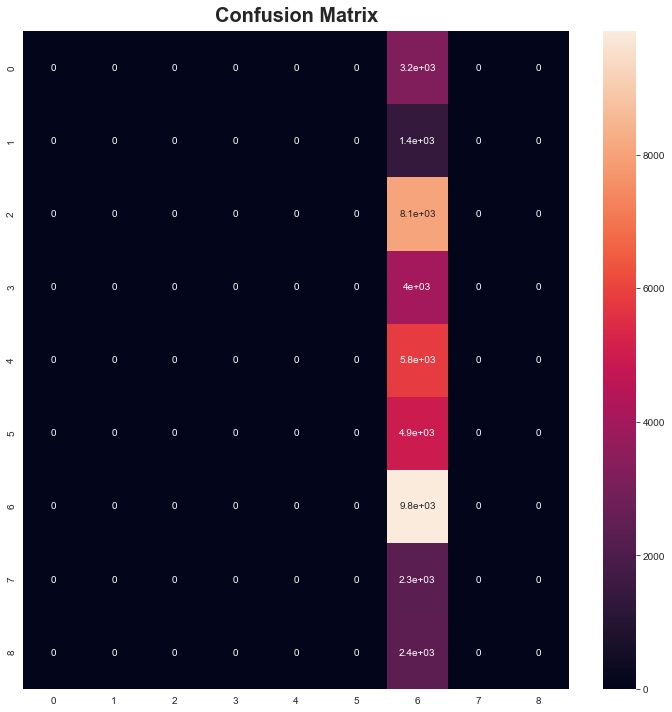

In [23]:
# evalute the model
test_loss, test_acc = model1.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history1)

Y_pred = model1.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 2

In [ ]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 93122


### Model training using embedding layer and RNN

In [ ]:
# basline model using embedding layers and simpleRNN
model2 = Sequential()
model2.add(Embedding(total_words, 70, input_length=maxlen))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model2.add(SimpleRNN(32, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Dense(9, activation='softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 70)            6518540   
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                

In [ ]:
model2.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 105s 92ms/step - loss: 0.5142 - accuracy: 0.8869 - val_loss: 4.9776 - val_accuracy: 0.2299
Epoch 2/15
1048/1048 [==============================] - 98s 93ms/step - loss: 0.4376 - accuracy: 0.9050 - val_loss: 6.9329 - val_accuracy: 0.2299
Epoch 3/15
1048/1048 [==============================] - 97s 93ms/step - loss: 0.3864 - accuracy: 0.9217 - val_loss: 6.2106 - val_accuracy: 0.2299
Epoch 4/15
1048/1048 [==============================] - 95s 91ms/step - loss: 0.3664 - accuracy: 0.9267 - val_loss: 6.4708 - val_accuracy: 0.2299
Epoch 5/15
1048/1048 [==============================] - 95s 91ms/step - loss: 0.3773 - accuracy: 0.9187 - val_loss: 7.1173 - val_accuracy: 0.2299
Epoch 6/15
1048/1048 [==============================] - 96s 91ms/step - loss: 0.4151 - accuracy: 0.9118 - val_loss: 6.1105 - val_accuracy: 0.2299
Epoch 7/15
1048/1048 [==============================] - 98s 93ms/step - loss: 0.3967 - accuracy: 0.9196 - val_loss: 7.6871 

In [ ]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


Test loss and accuracy: 7.42554235458374 0.19207732379436493


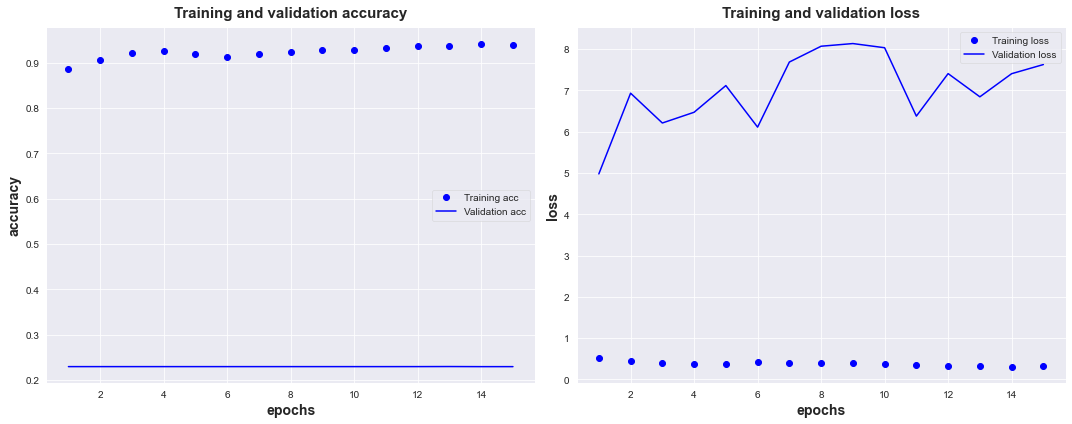

(41905,) (41905,)
[6 6 0 5 6] [2 2 2 2 2]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3165
           1       0.00      0.00      0.00      1379
           2       0.19      1.00      0.32      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.07      0.00      0.00      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.19     41905
   macro avg       0.03      0.11      0.04     41905
weighted avg       0.05      0.19      0.06     41905



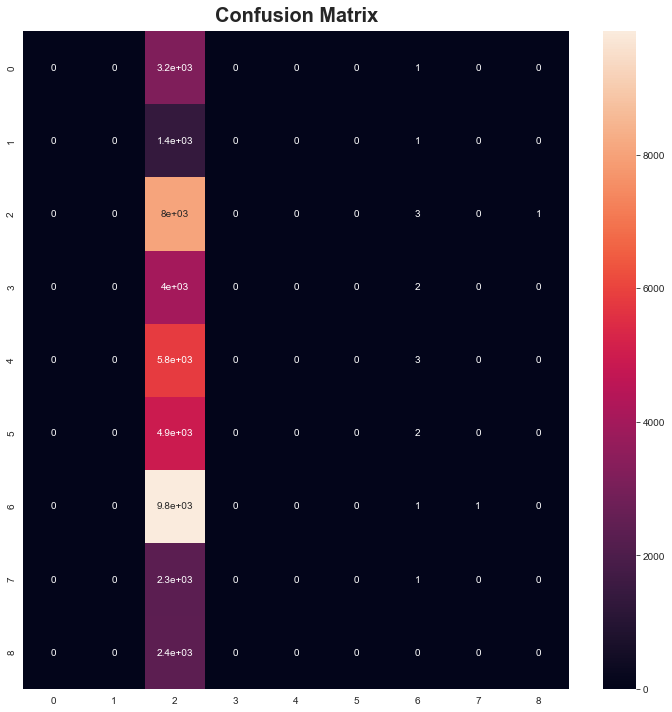

In [ ]:
# evalute the model
test_loss, test_acc = model2.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history2)

Y_pred = model2.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 3

In [4]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 93122


### Model training using embedding layer and RNN

In [5]:
# basline model using embedding layers and simpleRNN
model3 = Sequential()
model3.add(Embedding(total_words, 70, input_length=maxlen))
model3.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model3.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model3.add(SimpleRNN(32, activation='tanh'))
model3.add(Dropout(0.2))
model3.add(Dense(9, activation='softmax'))
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 70)            6518540   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          17280     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 9)                 2

In [6]:
model3.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history3 = model3.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 106s 93ms/step - loss: 0.2271 - accuracy: 0.9673 - val_loss: 3.4503 - val_accuracy: 0.2655
Epoch 2/15
1048/1048 [==============================] - 100s 96ms/step - loss: 0.1961 - accuracy: 0.9712 - val_loss: 4.0415 - val_accuracy: 0.2655
Epoch 3/15
1048/1048 [==============================] - 102s 97ms/step - loss: 0.1780 - accuracy: 0.9756 - val_loss: 3.6258 - val_accuracy: 0.2655
Epoch 4/15
1048/1048 [==============================] - 100s 96ms/step - loss: 0.1459 - accuracy: 0.9808 - val_loss: 4.4753 - val_accuracy: 0.2655
Epoch 5/15
1048/1048 [==============================] - 101s 96ms/step - loss: 0.1530 - accuracy: 0.9818 - val_loss: 4.3040 - val_accuracy: 0.2655
Epoch 6/15
1048/1048 [==============================] - 104s 99ms/step - loss: 0.1320 - accuracy: 0.9838 - val_loss: 4.7349 - val_accuracy: 0.2655
Epoch 7/15
1048/1048 [==============================] - 119s 114ms/step - loss: 0.1350 - accuracy: 0.9837 - val_loss: 

In [7]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


Test loss and accuracy: 8.304137229919434 0.07552798092365265


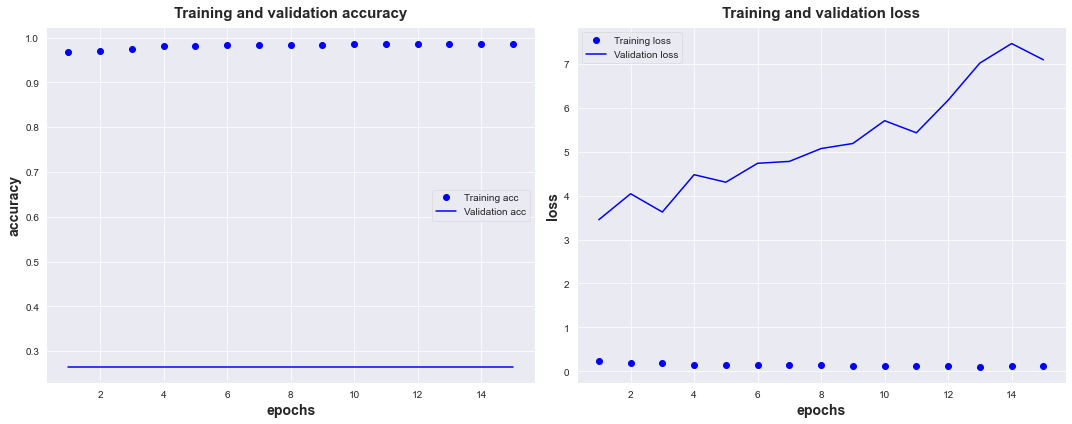

(41905,) (41905,)
[6 6 0 5 6] [0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.08      1.00      0.14      3165
           1       0.00      0.00      0.00      1379
           2       0.00      0.00      0.00      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.00      0.00      0.00      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.08     41905
   macro avg       0.01      0.11      0.02     41905
weighted avg       0.01      0.08      0.01     41905



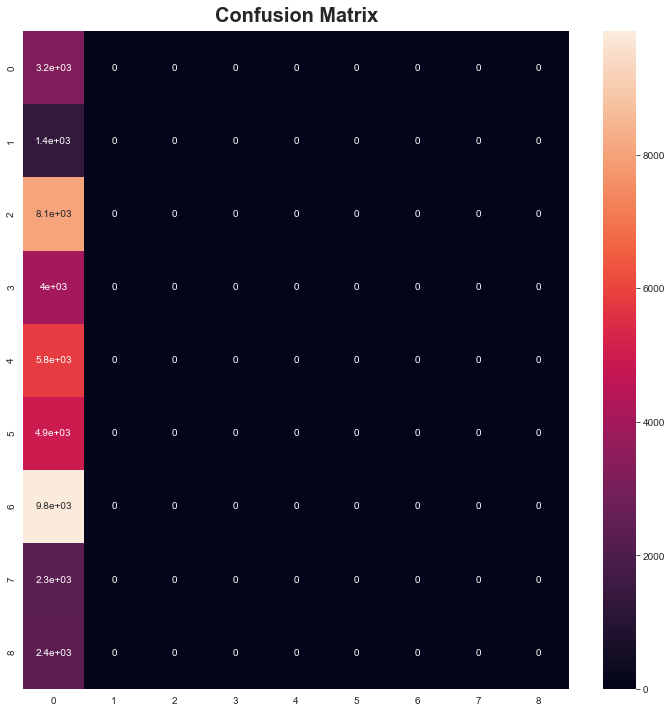

In [10]:
# evalute the model
test_loss, test_acc = model3.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history3)

Y_pred = model3.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 4

In [11]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 93122


### Model training using embedding layer and RNN (Baseline)

In [12]:
# basline model using embedding layers and simpleRNN
model4 = Sequential()
model4.add(Embedding(total_words, 70, input_length=maxlen))
model4.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model4.add(SimpleRNN(32, activation='tanh'))
model4.add(Dropout(0.2))
model4.add(Dense(9, activation='softmax'))
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 70)            6518540   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                

In [13]:
model4.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history4 = model4.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 107s 95ms/step - loss: 0.2781 - accuracy: 0.9569 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 2/15
1048/1048 [==============================] - 98s 94ms/step - loss: 0.1868 - accuracy: 0.9706 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 3/15
1048/1048 [==============================] - 100s 96ms/step - loss: 0.1864 - accuracy: 0.9750 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 4/15
1048/1048 [==============================] - 101s 97ms/step - loss: 0.1855 - accuracy: 0.9740 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 5/15
1048/1048 [==============================] - 99s 94ms/step - loss: 0.1687 - accuracy: 0.9744 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 6/15
1048/1048 [==============================] - 99s 95ms/step - loss: 0.1485 - accuracy: 0.9804 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/15
1048/1048 [==============================] - 102s 97ms/step - loss: 0.1582 - accuracy: 0.9781 - val_loss: 0.00

In [14]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


Test loss and accuracy: 7.597177982330322 0.23496003448963165


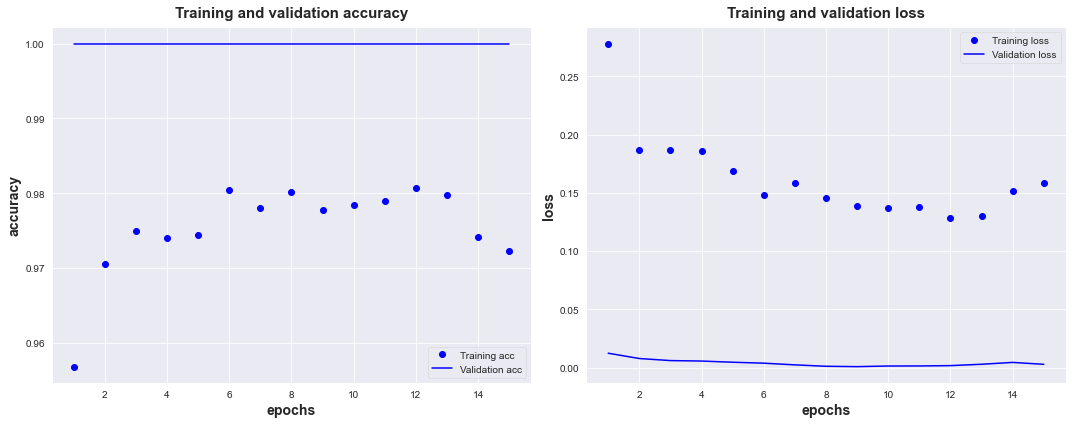

(41905,) (41905,)
[6 6 0 5 6] [6 6 6 6 6]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3165
           1       0.00      0.00      0.00      1379
           2       0.00      0.00      0.00      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.23      1.00      0.38      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.23     41905
   macro avg       0.03      0.11      0.04     41905
weighted avg       0.06      0.23      0.09     41905



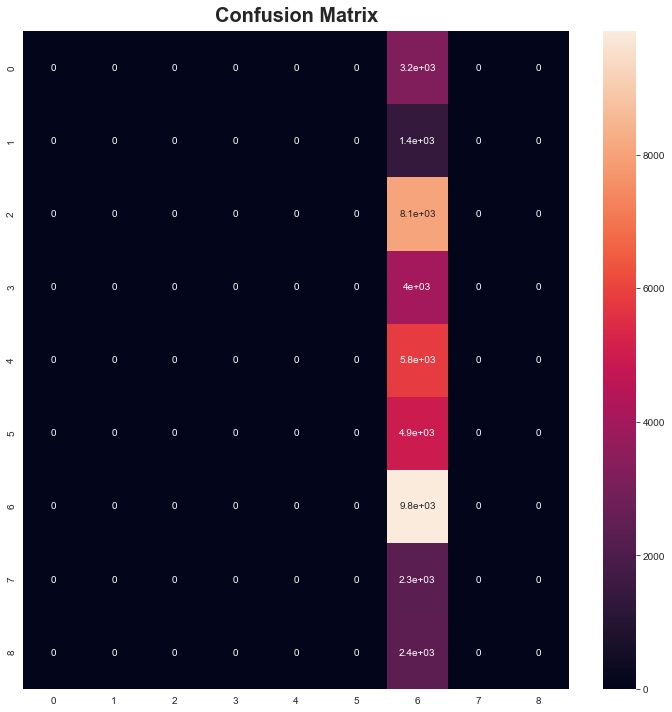

In [15]:
# evalute the model
test_loss, test_acc = model4.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history4)

Y_pred = model4.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 5

In [16]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 93122


### Model training using embedding layer and RNN (Baseline)

In [17]:
# basline model using embedding layers and simpleRNN
model5 = Sequential()
model5.add(Embedding(total_words, 70, input_length=maxlen))
model5.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model5.add(SimpleRNN(32, activation='tanh'))
model5.add(Dropout(0.2))
model5.add(Dense(9, activation='softmax'))
model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 70)            6518540   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                

In [18]:
model5.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history5 = model5.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 94s 82ms/step - loss: 0.2493 - accuracy: 0.9613 - val_loss: 3.5750 - val_accuracy: 0.2655
Epoch 2/15
1048/1048 [==============================] - 84s 80ms/step - loss: 0.1345 - accuracy: 0.9782 - val_loss: 4.3052 - val_accuracy: 0.2655
Epoch 3/15
1048/1048 [==============================] - 84s 80ms/step - loss: 0.1791 - accuracy: 0.9738 - val_loss: 4.4694 - val_accuracy: 0.2655
Epoch 4/15
1048/1048 [==============================] - 84s 80ms/step - loss: 0.1461 - accuracy: 0.9814 - val_loss: 5.1986 - val_accuracy: 0.2655
Epoch 5/15
1048/1048 [==============================] - 92s 88ms/step - loss: 0.1452 - accuracy: 0.9820 - val_loss: 5.2398 - val_accuracy: 0.2655
Epoch 6/15
1048/1048 [==============================] - 96s 91ms/step - loss: 0.1394 - accuracy: 0.9842 - val_loss: 5.8660 - val_accuracy: 0.2655
Epoch 7/15
1048/1048 [==============================] - 97s 92ms/step - loss: 0.1256 - accuracy: 0.9851 - val_loss: 5.4830 -

In [19]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


Test loss and accuracy: 7.748198509216309 0.07552798092365265


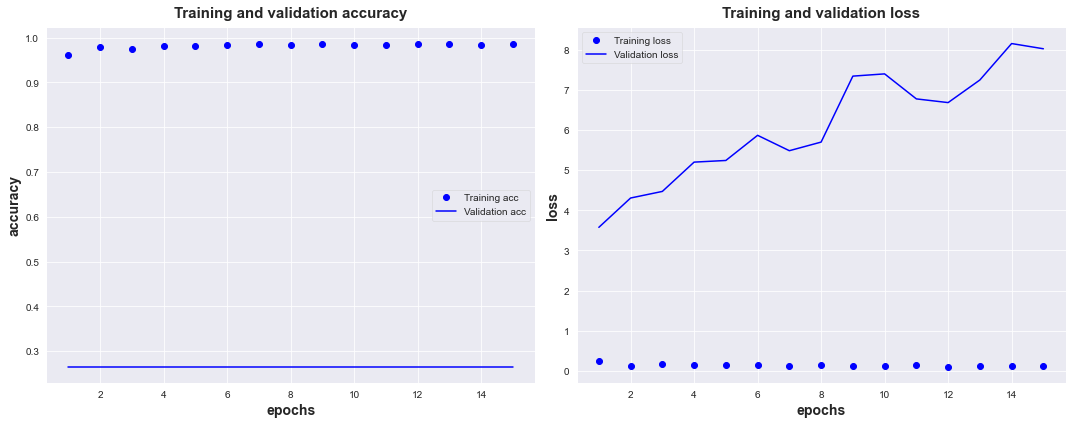

(41905,) (41905,)
[6 6 0 5 6] [0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.08      1.00      0.14      3165
           1       0.00      0.00      0.00      1379
           2       0.00      0.00      0.00      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.00      0.00      0.00      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.08     41905
   macro avg       0.01      0.11      0.02     41905
weighted avg       0.01      0.08      0.01     41905



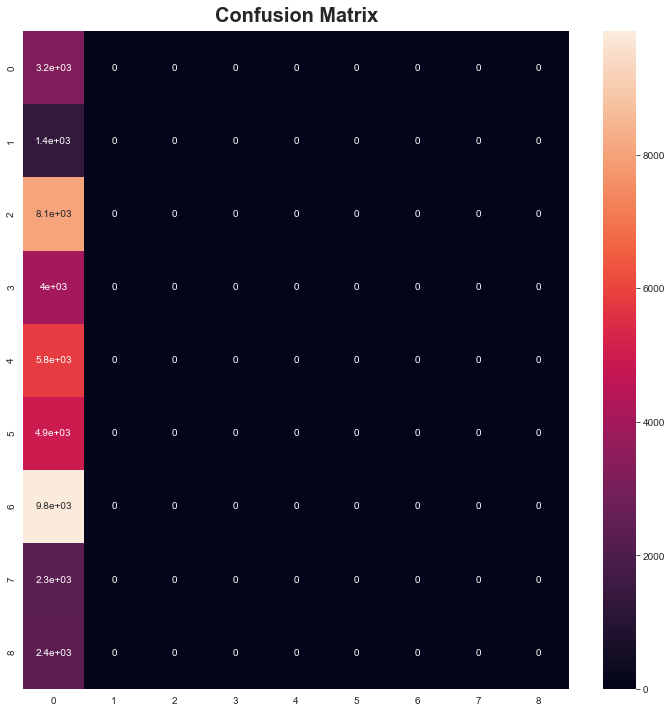

In [20]:
# evalute the model
test_loss, test_acc = model5.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history5)

Y_pred = model5.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);